In [1]:
import Pkg; 
Pkg.activate(".."); Pkg.instantiate();
using RxInfer, Random, Plots, StableRNGs

  Activating project at `/ws`
┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ nothing /ws/Manifest.toml:0


#### Goal
Single position inference based on 2 types of measurements. 
$$
y_1 = x + v \\
y_2 = exp(x + u)
$$
with
$$
v, u = \mathcal{N}(0, 1)
$$
#### Datageneration

In [2]:
Random.seed!(42)
x = 1

1

In [3]:
function generate_y1(x, v, N)
  noise = rand(Normal(0, v), N)
  y = x .+ noise
  return y
end

function generate_y2(x, u, N)
  noise = rand(Normal(0, u), N)
  y = 3*x .+ noise
end

generate_y2 (generic function with 1 method)

In [4]:
println("y1: ", generate_y1(x, 1, 2))
println("y2: ", generate_y2(x, 1, 2))

y1: [1.7883556016042919, 0.1201414040456007]
y2: [2.126206517790374, 2.2667450355651075]


In [5]:
# Define the datastreams
y1_data = generate_y1(x, 5, 100)
y2_data = generate_y2(x, 5, 200)


200-element Vector{Float64}:
  2.740094165829563
  5.271784055019643
  6.55957759099498
 -0.5984401981370775
 10.158389812685417
  7.644910430788063
 -2.705093090540613
  3.696353798367675
  6.245617712970631
 -6.054958979452234
  ⋮
  6.701578605910809
  6.071072134363351
  1.611362802643138
 -1.8696515708126915
  6.854636788598578
  5.11904247391236
  2.129380256028079
  9.033980869706378
 10.929733106988321

#### Model Definiton

In [6]:
@model function model(mu, sigma, y1, y2)
  x ~ Normal(mean=mu, variance=sigma)
  y1 ~ Normal(mean=x, variance=5)
  y2 ~ Normal(mean=3*x, variance=5)
end

model_autoupdates = @autoupdates begin
  mu = mean(q(x))
  sigma = var(q(x))
end

@autoupdates begin
    mu = mean(q(x))
    sigma = var(q(x))
end


In [7]:
imarginals = @initialization begin
  q(x) = Normal(1, 1.0)
  q(y1) = Normal(0.0, 1.0)
  q(y2) = Normal(0.0, 1.0)
end

ireturnvars = (
  x = KeepLast()
)

result = infer(
  model          = model(),
  data           = (y1 = y1_data, y2 = y2_data),
  autoupdates    = model_autoupdates,
  initialization = imarginals,
  keephistory    = 100,
  historyvars    = ireturnvars,
  autostart      = true 
)


RxInferenceEngine:
  Posteriors stream    | enabled for (anonymous_var_graphppl, x)
  Free Energy stream   | disabled
  Posteriors history   | available for (x)
  Free Energy history  | unavailable
  Enabled events       | [  ]

┌ Info: Saved animation to /ws/notebooks/figures/inference.gif
└ @ Plots /root/.julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("/ws/notebooks/figures/inference.gif")
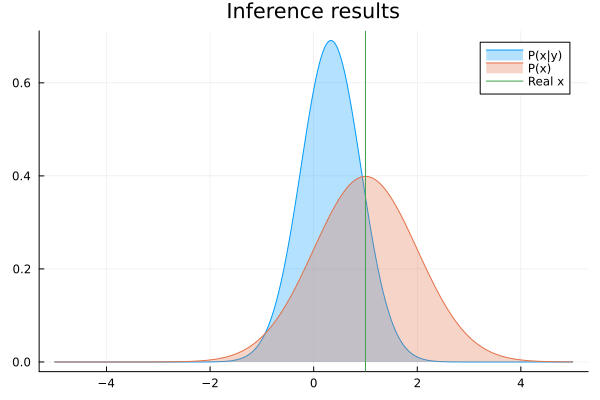

In [8]:
x_estimated = result.history[:x]

anim = @animate for x in x_estimated
  r = range(-5, 5, length=1000)
  p = plot(title = "Inference results")
  p = plot!(r, (y)->pdf(x, y), fillalpha=0.3, fillrange=0, label="P(x|y)")
  p = plot!(r, (y)->pdf(Normal(1, 1), y), fillalpha=0.3, fillrange=0, label="P(x)")
  p = vline!([1], label="Real x")
end

gif(anim, "figures/inference.gif", fps = 5)